In [1]:
import tensorflow as tf
from model.dataset import load_dataset, transform_image, transform_output
from model.utils import load_anchors, draw_outputs
from model.masknet import YoloMaskNet2
from model.yolo import YoloLoss, YoloBox, YoloNMS, YoloV3
import numpy as np
from model.utils import draw_outputs, load_classes
import matplotlib.pyplot as plt
import cv2

In [12]:
size = (416, 416)
classes_names = load_classes("utils/fddb.categories.txt")
anchors, masks = load_anchors("utils/fddb_anchor9.txt")
anchors = anchors/416
batch_size = 32
print("Anchors:", anchors.shape)
print("Masks:", masks.shape)

Anchors: (9, 2)
Masks: (3, 3)


In [3]:
model = YoloMaskNet2(anchors, masks, 2, training=True)
model.build((1, 416, 416, 3))
# model.load_weights("masknetv4.h5")
model.layers[0].load_weights("darknet53.h5")

In [4]:
model.summary()

Model: "yolo_mask_net2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
yolo_darknet (Darknet53)     multiple                  40620640  
_________________________________________________________________
yolo_conv (YoloConv)         multiple                  11024384  
_________________________________________________________________
yolo_output (YoloOutput)     multiple                  4744213   
_________________________________________________________________
yolo_conv_1 (YoloConv)       multiple                  2957312   
_________________________________________________________________
yolo_output_1 (YoloOutput)   multiple                  1192469   
_________________________________________________________________
yolo_conv_2 (YoloConv)       multiple                  741376    
_________________________________________________________________
yolo_output_2 (YoloOutput)   multiple               

In [13]:
# Load dataset
train_dataset = load_dataset("utils/train.tfrecord", size)
# train_dataset = train_dataset.shuffle(buffer_size=1)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.map(lambda x, y: (
                        transform_image(x, size),
                        transform_output(y, anchors, masks, grid_size=13)
                ))
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# data validasi
val_dataset = load_dataset("utils/val.tfrecord", size)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.map(lambda x, y: (
                        transform_image(x, size),
                        transform_output(y, anchors, masks, grid_size=13)
                ))


In [6]:
# initialize hyperparameter
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
loss = YoloLoss(anchors[masks[0]], 2, class_loss='sparse_binary')
loss_61 = YoloLoss(anchors[masks[1]], 2, class_loss='sparse_binary')
loss_36 = YoloLoss(anchors[masks[2]], 2, class_loss='sparse_binary')
epochs=10

In [7]:
for layer in model.layers:
    print(layer.trainable)

True
True
True
True
True
True
True


In [8]:
# freeze darknetnya
model.darknet53.dnconv1.trainable = False
model.darknet53.dnblock1.trainable = False
model.darknet53.dnblock2.trainable = False
model.darknet53.dnblock3.trainable = False
model.darknet53.dnblock4.trainable = False
model.darknet53.dnblock5.trainable = False

In [9]:
# model.load_weights("masknetv5.h5")
model.summary()

Model: "yolo_mask_net2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
yolo_darknet (Darknet53)     multiple                  40620640  
_________________________________________________________________
yolo_conv (YoloConv)         multiple                  11024384  
_________________________________________________________________
yolo_output (YoloOutput)     multiple                  4744213   
_________________________________________________________________
yolo_conv_1 (YoloConv)       multiple                  2957312   
_________________________________________________________________
yolo_output_1 (YoloOutput)   multiple                  1192469   
_________________________________________________________________
yolo_conv_2 (YoloConv)       multiple                  741376    
_________________________________________________________________
yolo_output_2 (YoloOutput)   multiple               

In [10]:
# Compile model
model.compile(optimizer=optimizer, loss=[loss, loss_61, loss_36])

In [14]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, verbose=1)

Epoch 1/10
183/183 [==============================] - 226s 1s/step - loss: 365.7031 - output_1_loss: 27.0054 - output_2_loss: 76.8456 - output_3_loss: 250.9459 - val_loss: 127.5424 - val_output_1_loss: 10.4720 - val_output_2_loss: 14.5396 - val_output_3_loss: 91.6021
Epoch 2/10
183/183 [==============================] - 215s 1s/step - loss: 38.3186 - output_1_loss: 6.3978 - output_2_loss: 5.4714 - output_3_loss: 15.5264 - val_loss: 46.4704 - val_output_1_loss: 9.9409 - val_output_2_loss: 9.4263 - val_output_3_loss: 16.1866
Epoch 3/10
183/183 [==============================] - 215s 1s/step - loss: 27.9670 - output_1_loss: 4.9717 - output_2_loss: 3.5242 - output_3_loss: 8.5614 - val_loss: 38.4756 - val_output_1_loss: 9.9962 - val_output_2_loss: 8.8903 - val_output_3_loss: 8.6874
Epoch 4/10
183/183 [==============================] - 215s 1s/step - loss: 23.0431 - output_1_loss: 3.9756 - output_2_loss: 2.5886 - output_3_loss: 5.5863 - val_loss: 36.9842 - val_output_1_loss: 10.2395 - val_ou

In [27]:
model.save_weights("masknetv6.h5")

In [54]:
file = open("test5.jpg", "rb").read()
img_in = tf.image.decode_jpeg(file, channels=3)
img_in = transform_image(img_in, size)
img_in = tf.expand_dims(img_in, axis=0)

In [55]:
output_1, output_2, output_3 = model.predict(img_in)
boxes_0 = YoloBox(output_1, anchors[masks[0]], 2)
boxes_1 = YoloBox(output_2, anchors[masks[1]], 2)
boxes_2 = YoloBox(output_3, anchors[masks[2]], 2)
boxes, scores, classes, nums = YoloNMS((boxes_0[:3], boxes_1[:3], boxes_2[:3]), 
                                       anchors, masks, 2, iou_threshold=0.5, score_threshold=0.1)

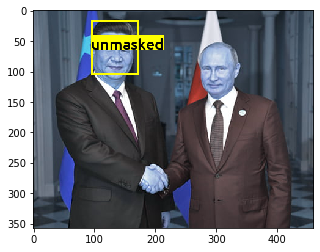

In [57]:
# boxes, scores, classes, nums = model.predict(img)
img = cv2.imread("test5.jpg")
img = draw_outputs(img, (boxes, scores, classes, nums), classes_names)
plt.imshow(img)
plt.show()

In [53]:
scores

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[0.95004725, 0.5395742 , 0.44470307, 0.431277  , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        

In [64]:
nums

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([4])>

In [37]:
classes

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0.]], dtype=float32)>

In [37]:
model.layers

In [43]:
output_1.shape

(1, 13, 13, 3, 6)

In [47]:
for i in range(13):
    for j in range(13):
        for a in range(3):
            print(tf.sigmoid(output_1[0][i][j][a][4]).numpy())

3.6053063e-07
7.787311e-08
4.428993e-08
3.340998e-09
8.343529e-12
8.813124e-13
0.9998896
0.0014950195
4.955716e-06
1.5877496e-06
8.284583e-09
1.2355084e-12
0.99868065
0.0014077122
1.27776975e-05
0.00015241506
2.4840479e-06
1.0152187e-08
4.2696785e-05
1.9837814e-06
1.4334493e-07
0.00016367166
3.503028e-07
1.7749759e-09
4.770568e-08
2.7506577e-09
1.2013731e-09
3.9124293e-07
0.00034947973
2.3973772e-07
3.3914638e-08
3.438543e-12
2.721715e-16
7.09996e-14
4.828828e-06
6.2990477e-12
2.7359046e-15
1.5911767e-15
6.4462215e-24
4.4690473e-06
3.0230947e-08
1.8867008e-09
0.6767886
0.9915433
0.9367738
0.15436149
5.665899e-13
1.6102579e-08
0.0035310762
5.7880045e-10
6.2326535e-07
8.898465e-05
8.036572e-09
4.3657433e-09
0.70962286
0.01619434
0.00024495248
4.1447956e-06
1.3845092e-08
1.26084805e-08
0.0004864782
2.0588147e-06
6.0842735e-06
2.9632827e-06
2.4540155e-05
1.5893069e-06
4.1718285e-11
8.4552434e-11
5.920518e-10
0.9881024
8.922204e-08
1.4025798e-09
2.9650065e-16
4.0999773e-20
1.3881697e-18
2.8

In [50]:
for i in range(13):
    for j in range(13):
        for a in range(3):
            print(boxes_1[0][i][j][a][])

(<tf.Tensor: shape=(1, 26, 26, 3, 4), dtype=float32, numpy=
 array([[[[[-7.03825131e-02, -7.66126513e-02,  2.04668418e-01,
             2.04210311e-01],
           [-6.58170581e-02, -1.64427355e-01,  1.84803143e-01,
             3.71610761e-01],
           [-1.26986668e-01, -1.88559577e-01,  2.84692407e-01,
             4.21870649e-01]],
 
          [[-1.57313123e-02, -7.10415095e-02,  1.75263047e-01,
             1.98481783e-01],
           [-8.49318504e-03, -1.70215011e-01,  1.56198442e-01,
             3.90908241e-01],
           [-5.52180335e-02, -1.85409248e-01,  2.13024139e-01,
             4.29938912e-01]],
 
          [[ 1.99175030e-02, -9.60488468e-02,  1.67546794e-01,
             2.57186681e-01],
           [ 1.41471699e-02, -2.00055853e-01,  1.65980488e-01,
             4.55783725e-01],
           [ 3.87956277e-02, -1.91268727e-01,  1.28368139e-01,
             4.50382203e-01]],
 
          ...,
 
          [[ 8.31921458e-01, -6.64476231e-02,  1.68588251e-01,
             1

In [51]:
len(boxes_0)

4

In [52]:
boxes_0[2]

<tf.Tensor: shape=(1, 13, 13, 3, 1), dtype=float32, numpy=
array([[[[[1.83513407e-06],
          [2.69337288e-05],
          [7.47044027e-01]],

         [[7.55264948e-11],
          [2.54693782e-06],
          [9.14908171e-01]],

         [[1.00830082e-04],
          [2.74065232e-11],
          [6.78377177e-08]],

         [[4.36898205e-07],
          [1.35659093e-06],
          [4.20047436e-03]],

         [[7.13076675e-04],
          [3.20630329e-06],
          [1.57997082e-03]],

         [[1.80888364e-05],
          [2.00786762e-05],
          [4.10664221e-03]],

         [[2.50188197e-04],
          [9.10701237e-06],
          [1.59775582e-03]],

         [[9.80881814e-05],
          [4.66668716e-05],
          [7.42599322e-03]],

         [[2.69846328e-06],
          [2.78610014e-03],
          [4.24737245e-01]],

         [[2.66494090e-03],
          [1.11079228e-03],
          [2.25072727e-01]],

         [[1.02618749e-07],
          [7.61932051e-06],
          [9.18311626e-02

In [194]:
def YoloNMS2(outputs, anchors, masks, classes, iou_threshold=0.5, score_threshold=0.5, class_type='categorical', binary_threshold=0.5):
    # boxes, conf, type
    b, c, t = [], [], []

    for o in outputs:
        xy = o[0][..., 0:2]
        wh = o[0][..., 2:4] + xy
        xywh = tf.concat([xy, wh], axis=-1)
        b.append(tf.reshape(xywh, (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))

    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)
    if class_type == 'binary':
        first = tf.cast(class_probs < binary_threshold, tf.float32)
        second = tf.cast(class_probs >= binary_threshold, tf.float32)
        class_probs = tf.concat([first, second], axis=-1)

    scores = confidence * class_probs
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=100,
        max_total_size=100,
        iou_threshold=iou_threshold,
        score_threshold=score_threshold
    )

    return boxes, scores, classes, valid_detections, class_probs

In [66]:
outputs = (boxes_0[:3], boxes_1[:3], boxes_2[:3])

In [67]:
b, c, t = [], [], []

for o in outputs:
    xy = o[0][..., 0:2]
    wh = o[0][..., 2:4] + xy
    xywh = tf.concat([xy, wh], axis=-1)
    b.append(tf.reshape(xywh, (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
    c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
    t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))

In [77]:
bbox = tf.concat(b, axis=1).numpy()
confident = tf.concat(c, axis=1).numpy()
class_probs = tf.concat(t, axis=1).numpy()

In [82]:
confident_mask = confident > 0.5

In [84]:
confident_mask.shape

(1, 10647, 1)

In [87]:
for i in range(10647):
    print(confident_mask[0][i][0])

False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fal

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [131]:
m = class_probs[cm]

In [129]:
cm = class_probs < 0.5

In [93]:
um = tf.cast(class_probs >= 0.5, tf.int32)

In [96]:
cc = tf.concat([m, um], axis=-1)

In [100]:
cc * confident

<tf.Tensor: shape=(1, 10647, 2), dtype=int32, numpy=
array([[[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]]])>

In [130]:
cm

array([[[ True],
        [ True],
        [False],
        ...,
        [ True],
        [ True],
        [ True]]])

In [133]:
m.shape

(9212,)

In [134]:
class_probs.shape

(1, 10647, 1)

In [12]:
for x, y in train_dataset:
    break

In [16]:
true_box, true_obj, true_class_idx = tf.split(tf.expand_dims(y[0], 0), (4, 1, 1), axis=-1)

In [21]:
tf.squeeze(tf.one_hot(tf.cast(true_class_idx, tf.uint8), 2, axis=-1), axis=-2) 

<tf.Tensor: shape=(1, 64, 13, 13, 3, 2), dtype=float32, numpy=
array([[[[[[1., 0.],
           [1., 0.],
           [1., 0.]],

          [[1., 0.],
           [1., 0.],
           [1., 0.]],

          [[1., 0.],
           [1., 0.],
           [1., 0.]],

          ...,

          [[1., 0.],
           [1., 0.],
           [1., 0.]],

          [[1., 0.],
           [1., 0.],
           [1., 0.]],

          [[1., 0.],
           [1., 0.],
           [1., 0.]]],


         [[[1., 0.],
           [1., 0.],
           [1., 0.]],

          [[1., 0.],
           [1., 0.],
           [1., 0.]],

          [[1., 0.],
           [1., 0.],
           [1., 0.]],

          ...,

          [[1., 0.],
           [1., 0.],
           [1., 0.]],

          [[1., 0.],
           [1., 0.],
           [1., 0.]],

          [[1., 0.],
           [1., 0.],
           [1., 0.]]],


         [[[1., 0.],
           [1., 0.],
           [1., 0.]],

          [[1., 0.],
           [1., 0.],
           [1.

In [26]:
model.darknet53.dnconv1.trainable = True
model.darknet53.dnblock1.trainable = True
model.darknet53.dnblock2.trainable = True
model.darknet53.dnblock3.trainable = True
model.darknet53.dnblock4.trainable = True
model.darknet53.dnblock5.trainable = True